In [22]:
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../")
from collections import defaultdict
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import matplotlib

In [23]:
def behaviour_policy(nA):
    A = np.ones(nA, dtype=float)/nA
    def random_policy(state):
        return A
    return random_policy

In [24]:
def target_policy(Q):
    def greedy_policy(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return greedy_policy

In [25]:
def off_monte_carlo_control(env, num_episodes, b_policy, discount=1.0):
    Q = defaultdict(lambda : np.zeros(env.action_space.n, dtype=float))
    C = defaultdict(lambda : np.zeros(env.action_space.n, dtype=float))
    
    t_policy  = target_policy(Q)
    
    for i in range(num_episodes):
        episode = []
        state = env.reset()
        for t in range(100):
            action_probs = b_policy(state)
            action = np.random.choice(np.arange(len(Q[state])) , p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        total_return = 0.0
        W = 1.0
        for p in reversed(episode):
            state, action, reward = tuple(p)
            total_return = discount*total_return + reward
            C[state][action] += W
            Q[state][action] += W/C[state][action] * (total_return - Q[state][action])
            if action != np.argmax(target_policy(state)):
                break
            W *= 1/b_policy(state)[action]
    return Q, t_policy
            

In [28]:
env = BlackjackEnv()
b_policy = behaviour_policy(env.action_space.n)
Q, policy = off_monte_carlo_control(env, num_episodes=500000, b_policy=b_policy)

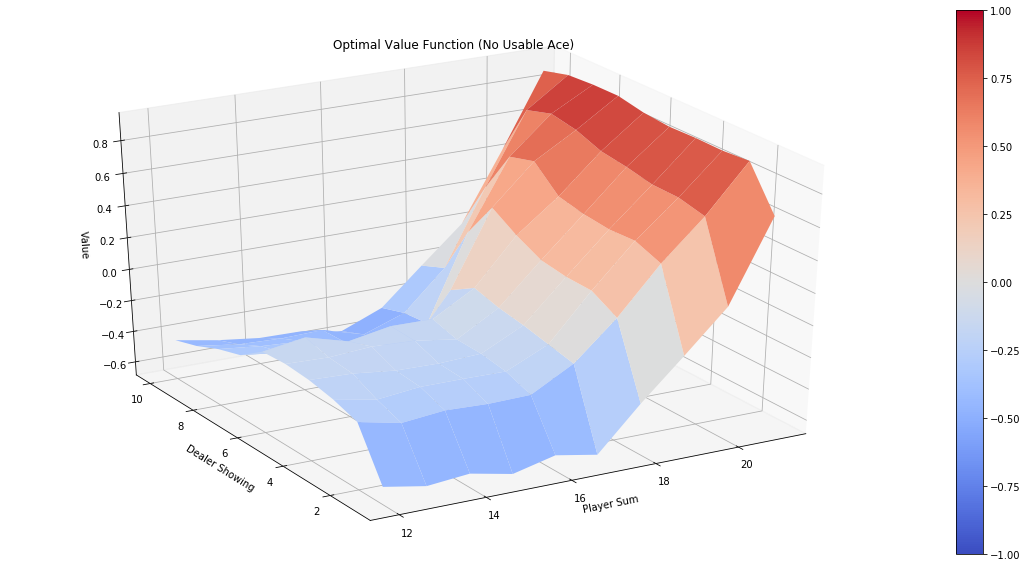

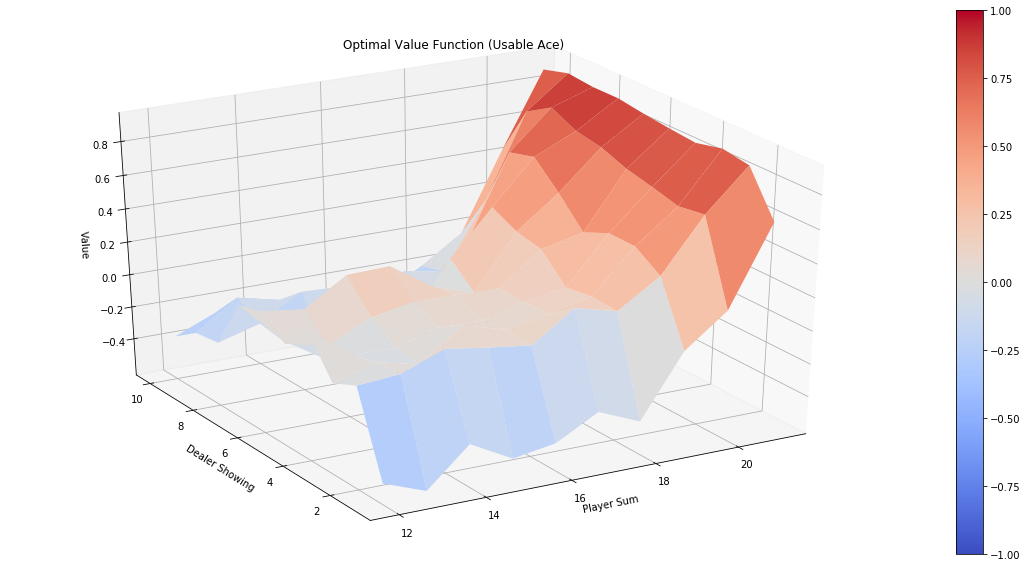

In [29]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")